In [50]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.python.framework import ops
import pickle

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# load mnist

In [3]:
mnist.train.images.shape

(55000, 784)

In [4]:
# Process MNIST (55000, 784)
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)

mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)

In [5]:
mnist_train.shape

(55000, 28, 28, 3)

# load MNIST-M

[mnistm_data.pkl download](https://drive.google.com/open?id=1Ik_PODRpQUPAY3tR-Wp-jFuBz-r0JG3B)

In [6]:
# Load MNIST-M
mnistm = pickle.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

- mean pixel

In [7]:
# average of each RGB
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))
pixel_mean.shape

(3,)

In [8]:
# Create a mixed dataset for TSNE visualization
num_test = 500
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])
combined_test_labels = np.vstack([mnist.test.labels[:num_test], mnist.test.labels[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
        np.tile([0., 1.], [num_test, 1])])

In [9]:
def imshow_grid(images, shape=[2, 8]):
    """Plot images in a grid of a given shape."""
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    plt.show()

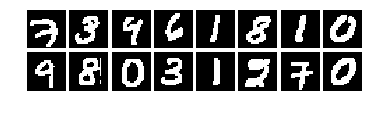

In [10]:
imshow_grid(mnist_train)

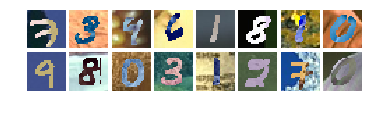

In [11]:
imshow_grid(mnistm_train)

- Placeholders 정의

In [12]:
batch_size = 64
X = tf.placeholder(tf.uint8, [None, 28, 28, 3])
y = tf.placeholder(tf.float32, [None, 10])
domainID = tf.placeholder(tf.float32, [None, 2])
lb = tf.placeholder(tf.float32, []) # lambda
lr = tf.placeholder(tf.float32, []) # learning rate
is_training = tf.placeholder(tf.bool, [])

- Input normalize

In [13]:
X_input = (tf.cast(X, tf.float32) - pixel_mean) / 255.
X_input

<tf.Tensor 'truediv:0' shape=(?, 28, 28, 3) dtype=float32>

---

# featureExtractor

- Conv block 정의

In [14]:
def conv_layer(inputs,
               name,
               kernelSize,
               inChannel,
               outChannel,
               stride = 1):        
    with tf.variable_scope(name) as name:
        convWeights = tf.get_variable(
                "W",
                shape= [kernelSize, kernelSize, inChannel, outChannel], 
                initializer=tf.initializers.truncated_normal(stddev=0.1)
                )

        convBiases = tf.get_variable(
                "b",
                shape=[outChannel],
                initializer=tf.constant_initializer(0.1)
                )

        conv = tf.nn.conv2d(inputs, convWeights, [1,stride,stride,1], padding='SAME')
        convBias = tf.nn.bias_add(conv, convBiases)

        relu = tf.nn.relu(convBias)

    return relu  

In [15]:
with tf.variable_scope('feature_extractor') as scope:
    
    # Conv1: n x 28(=(28-5+4)/1+1) x 28 x 32 ; 
    conv1 = conv_layer(X_input, kernelSize=5, name= "conv1", inChannel=3, outChannel=32) 

    # Pool1: n x 14(=(28-2)/2+1) x 14 x 32
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

    # Conv2: n x 14(=(14-5+4)/1+1) x 14 x 48
    conv2 = conv_layer(pool1, kernelSize=5, name= "conv2", inChannel=32, outChannel=48)

    # Pool2: n x 7(=(14-2)/2+1) x 7 x 48
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')
    
    # domain-invariant feature
    feature = tf.reshape(pool2, [-1, np.prod(pool2.shape.as_list()[1:])])

In [16]:
feature

<tf.Tensor 'feature_extractor/Reshape:0' shape=(?, 2352) dtype=float32>

---

# labelPredictor

- Train할때는 source/target domain을 구분하여 학습하고, Test할때는 데이터를 전부 학습해야한다.
- tf.cond를 사용하여 ifelse조건에 따라 함수1(for train) or 함수2(for test)를 반환한다.
- 그 함수의 형태로 바꿔주는 간단한 방법은 lambda를 사용하는 것이다.

- when training
    - tf.slice를 사용하여 soure데이터와 target데이터를 나눠준다.
    - [0, 0]: location
    - [batch_size // 2, -1]: location으로부터 batch_size // 2 행만큼, -1(2352) 열만큼 데이터를 잘라냄
    - 결국 주어진 데이터를 행으로 반으로 자르는 역할

In [17]:
# when training
source_features = lambda: tf.slice(feature, [0, 0], [batch_size // 2, -1])
source_labels = lambda: tf.slice(y, [0, 0], [batch_size // 2, -1])

# when testing
all_features = lambda: feature 
all_labels = lambda: y

In [18]:
# features/labels
training_features = tf.cond(is_training, source_features, all_features) 
true_labels = tf.cond(is_training, source_labels, all_labels)

In [19]:
def fc_layer(inputs,
             name,
            in_channel,
            out_channel, act_output = True): 
    
    with tf.variable_scope(name) as name:
        fcWeights = tf.get_variable(
                "W",
                shape= [in_channel, out_channel], 
                initializer=tf.initializers.truncated_normal(stddev=0.1)
                )

        fcBiases = tf.get_variable(
                "b",
                shape=[out_channel],
                initializer=tf.constant_initializer(0.1)
                )
        
        logit = tf.nn.bias_add(tf.matmul(inputs, fcWeights), fcBiases)

        if act_output==True:
            return tf.nn.relu(logit)

    return logit  

In [60]:
feature.shape.as_list()[-1]

2352

In [20]:
with tf.variable_scope('label_predictor') as scope:
    label_fc1_output= fc_layer(training_features, name ="fc1", in_channel= feature.shape.as_list()[-1], out_channel=100, act_output=True)
    label_fc2_output= fc_layer(label_fc1_output, name ="fc2", in_channel= 100, out_channel=100, act_output=True)
    label_fc3_output= fc_layer(label_fc2_output, name ="fc3", in_channel= 100, out_channel=10, act_output=False)

In [21]:
label_fc3_output

<tf.Tensor 'label_predictor/fc3/BiasAdd:0' shape=(?, 10) dtype=float32>

In [22]:
label_pred = tf.nn.softmax(label_fc3_output, axis = -1)
label_pred

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

In [23]:
# logit: label_fc3_output
pred_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=label_fc3_output, labels=true_labels)
pred_loss

<tf.Tensor 'softmax_cross_entropy_with_logits/Reshape_2:0' shape=(?,) dtype=float32>

---

# domainPredictor

- Gradient reverse layer를 구하는 방법을 살펴보자
    - Forward propagation: identity에 의해서 같은 값이 나옴
    - backward propagation: negative gradient(-lambda * gradient)이 계산됨

In [24]:
class FlipGradientBuilder(object):
    def __init__(self):
        self.num_calls = 0

    def __call__(self, x, lb=1.0):
        
        grad_name = "FlipGradient%d" % self.num_calls
        
        @ops.RegisterGradient(grad_name)
        def _flip_gradients(op, grad):
            return [tf.negative(grad) * lb]
        
        g = tf.get_default_graph()
        with g.gradient_override_map({"Identity": grad_name}):
            y = tf.identity(x) # copy for assign op
            
        self.num_calls += 1
        return y

---

- 위의 flip gradient를 적용하면 아래와 같다.
    - 논문에 제시된 $\lambda$를 learning rate와 같게 하였다.

In [25]:
flip_gradient = FlipGradientBuilder()

In [26]:
with tf.variable_scope('domain_predictor'):

    # Flip the gradient when backpropagating through this operation
    grad_reversed_feature = flip_gradient(feature, lb)
    domain_fc1_output= fc_layer(grad_reversed_feature, name ="fc1", in_channel= feature.shape.as_list()[-1], out_channel=100, act_output=True)
    domain_fc2_output= fc_layer(domain_fc1_output, name ="fc2", in_channel= 100, out_channel=2, act_output=False)
    

In [27]:
domain_pred = tf.nn.softmax(domain_fc2_output)

In [28]:
domain_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=domain_fc2_output, labels=domainID)
domain_loss

<tf.Tensor 'softmax_cross_entropy_with_logits_1/Reshape_2:0' shape=(?,) dtype=float32>

---

# loss

In [29]:
# loss
predLoss = tf.reduce_mean(pred_loss)
domainLoss = tf.reduce_mean(domain_loss)
totalLoss = predLoss + domainLoss

# train op
# label_train_op = tf.train.AdamOptimizer(0.9).minimize(predLoss)
DA_train_op = tf.train.MomentumOptimizer(lr,0.9).minimize(totalLoss)

# Accuacy
correct_label_pred = tf.equal(tf.argmax(true_labels, 1), tf.argmax(label_pred, 1)) #boolean
label_acc = tf.reduce_mean(tf.cast(correct_label_pred, tf.float32)) #scalar
correct_domain_pred = tf.equal(tf.argmax(domainID, 1), tf.argmax(domain_pred, 1))
domain_acc = tf.reduce_mean(tf.cast(correct_domain_pred, tf.float32))

---

# Session on

In [30]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [31]:
def shuffle_aligned_list(pairs):
    """Shuffle arrays in a list by shuffling each array identically."""
    num = pairs[0].shape[0]
    pm_idx = np.random.permutation(num)
    return [pair[pm_idx] for pair in pairs]


def batch_generator(pairs, batch_size, shuffle=True):
    """Generate batches of data.
    
    Given a list of array-like objects, generate batches of a given
    size by yielding a list of array-like objects corresponding to the
    same slice of each input.
    """
    if shuffle:
        pairs = shuffle_aligned_list(pairs)

    batch_num = 0
    while True:
        if batch_num * batch_size + batch_size >= len(pairs[0]):
            batch_num = 0

            if shuffle:
                pairs = shuffle_aligned_list(pairs)

        start = batch_num * batch_size
        end = start + batch_size
        batch_num += 1
        yield [pair[start:end] for pair in pairs]


- an half of source/target domain examples
- source/target domain examples을 반씩 잘라 붙여야 사전에 설정해 놓은 batch size랑 일치한다.
    - [(32, 28, 28, 3), (32, 10)]

In [32]:
gen_source_batch = batch_generator(pairs=[mnist_train, mnist.train.labels], batch_size= batch_size // 2)
gen_target_batch = batch_generator(pairs=[mnistm_train, mnist.train.labels], batch_size= batch_size // 2)

- All of source/target domain examples
    - [(64, 28, 28, 3), (64, 10)]

In [33]:
gen_source_only_batch = batch_generator(pairs=[mnist_train, mnist.train.labels],batch_size= batch_size)
gen_target_only_batch = batch_generator(pairs=[mnistm_train, mnist.train.labels], batch_size=batch_size)

- domain labels if source or target

In [34]:
domain_labels = np.vstack([np.tile([1., 0.], [batch_size // 2, 1]),
                           np.tile([0., 1.], [batch_size // 2, 1])])

In [35]:
# Training model
num_steps = 8600

for i in range(num_steps):

    # Adaptation param and learning rate schedule as described in the paper
    p = float(i) / num_steps # smaller over time
    _lb = 2. / (1. + np.exp(-10. * p)) - 1 # smaller over time
    _lr = 0.01 / (1. + 10 * p)**0.75 

    # Training step

    XS, yS = next(gen_source_batch)
    XT, yT = next(gen_target_batch)

    X_feed = np.vstack([XS, XT])
    y_feed = np.vstack([yS, yT])

    _, batch_loss, dloss, ploss, d_acc, p_acc = sess.run(
        [DA_train_op, totalLoss, domainLoss, predLoss, domain_acc, label_acc],
        feed_dict = {X: X_feed,
           y: y_feed,
           domainID: domain_labels,
           is_training: True,
           lb: _lb,
           lr: _lr})
    
    if i % 100 == 0:
        print('loss: {}  d_acc: {}  p_acc: {}  p: {}  lb: {}  lr: {}'.format(
                batch_loss, d_acc, p_acc, p, _lb, _lr))

loss: 4.825463771820068  d_acc: 0.5  p_acc: 0.0625  p: 0.0  lb: 0.0  lr: 0.01
loss: 0.40940043330192566  d_acc: 0.90625  p_acc: 0.9375  p: 0.011627906976744186  lb: 0.05807411547586794  lr: 0.009208108196143174
loss: 0.5818338394165039  d_acc: 0.890625  p_acc: 0.875  p: 0.023255813953488372  lb: 0.11575782577418603  lr: 0.008548589038554535
loss: 0.5852369666099548  d_acc: 0.796875  p_acc: 0.9375  p: 0.03488372093023256  lb: 0.1726711536624863  lr: 0.007989697680708598
loss: 0.5564760565757751  d_acc: 0.90625  p_acc: 0.9375  p: 0.046511627906976744  lb: 0.22845439143629886  lr: 0.0075092390442056635
loss: 0.35558179020881653  d_acc: 0.875  p_acc: 0.96875  p: 0.05813953488372093  lb: 0.28277682569099527  lr: 0.0070911987391239035
loss: 0.2507930397987366  d_acc: 0.9375  p_acc: 1.0  p: 0.06976744186046512  lb: 0.33534391863054624  lr: 0.006723713451795381
loss: 0.25439000129699707  d_acc: 0.953125  p_acc: 0.96875  p: 0.08139534883720931  lb: 0.3859026564904293  lr: 0.006397796023621206
l

# Evaluation

- 학습을 할때는 source/target데이터가 모두 필요하다.
- 평가할때 source 데이터 성능을 볼땐 source만, target 데이터 성능을 볼땐 target만 사용할 수 있다.
- 어떤 domain인지를 평가할때는 당연히 두개의 source/target 데이터가 필요하다.

In [36]:
# Compute final evaluation on test data
source_acc = sess.run(label_acc,
                    feed_dict={X: mnist_test, y: mnist.test.labels,
                               is_training: False})

target_acc = sess.run(label_acc,
                    feed_dict={X: mnistm_test, y: mnist.test.labels,
                               is_training: False})


test_domain_acc = sess.run(domain_acc,
                    feed_dict={X: combined_test_imgs,
                               domainID: combined_test_domain, lb: 1.0})

In [37]:
test_emb = sess.run(feature, feed_dict={X: combined_test_imgs})
test_emb.shape

(1000, 2352)

In [38]:
print('\nDomain adaptation training')
print('Source (MNIST) accuracy:', source_acc)
print('Target (MNIST-M) accuracy:', target_acc)
print('Domain accuracy:', test_domain_acc)


Domain adaptation training
Source (MNIST) accuracy: 0.9807
Target (MNIST-M) accuracy: 0.7198
Domain accuracy: 0.669


- 시각화를 위해 따로 임베딩 vector, domain, label를 뽑아 둠

In [55]:
if not os.path.exists('./results'):
    os.mkdir('./results') 
# images(source: 500, target: 500)
np.save('./results/SourceTargetImages.npy',combined_test_imgs)

# 2352차원을 가진 1000 vector(source: 500, target: 500)
np.save('./results/SourceTargetEmbed.npy', test_emb)

# source or target
np.save('./results/SourceTargetDomain.npy', combined_test_domain)

# mnist label
np.save('./results/SourceTargetLabels.npy', combined_test_labels)